In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import warnings
import sys
sys.path.insert(1, './python_helper_files/')
from post_processing_multi import * # Import data post processing functions
from plotting_helper import * # Import helper functions for plotting in ipynb
warnings.filterwarnings('ignore') # supress warnings for clenliness

# Loading data
Data is provided in a folder (or series of folders) and is loaded and processed with budget assignment by the ```load_multiple_files_budget``` function. This is wrapped in the load_max_cut_data. This takes a long time due to the large number of files that needs to be processed. If data were stored differently (i.e. in a database), this would be much faster. 

In [9]:

if Path("./MaxCut_runs/filtered_df.pkl").is_file():
    maxcut_df=pd.read_pickle('./MaxCut_runs/filtered_df.pkl') 
else:
    maxcut_df = load_all_data() #Only load data from files if there is no database
    maxcut_df.to_pickle('./MaxCut_runs/filtered_df.pkl') 
    maxcut_df.to_csv('./MaxCut_runs/filtered_df.csv')

## Plots from the main text

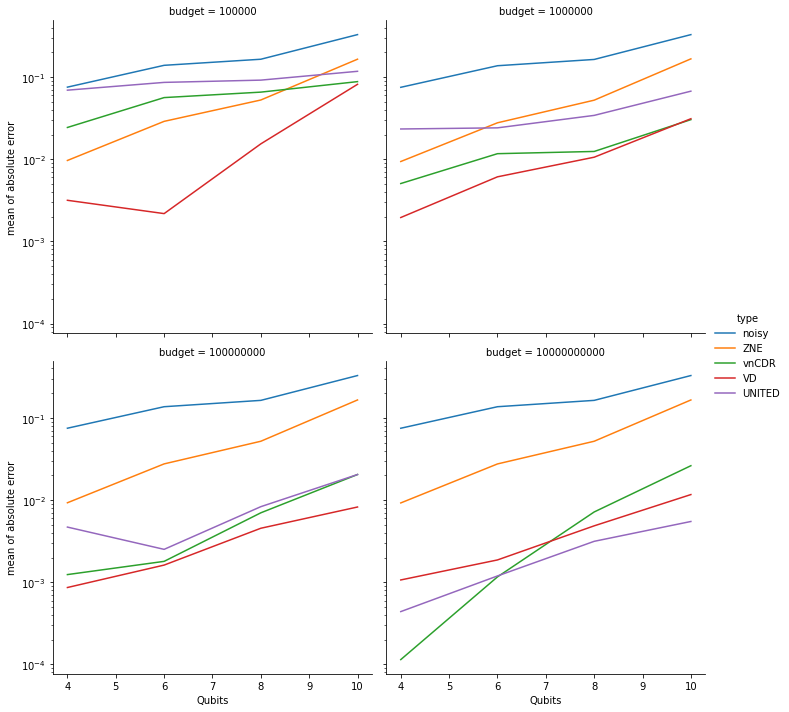

In [3]:
figure_4(maxcut_df,'mean') # Can plot other standard statistical values, can be None.

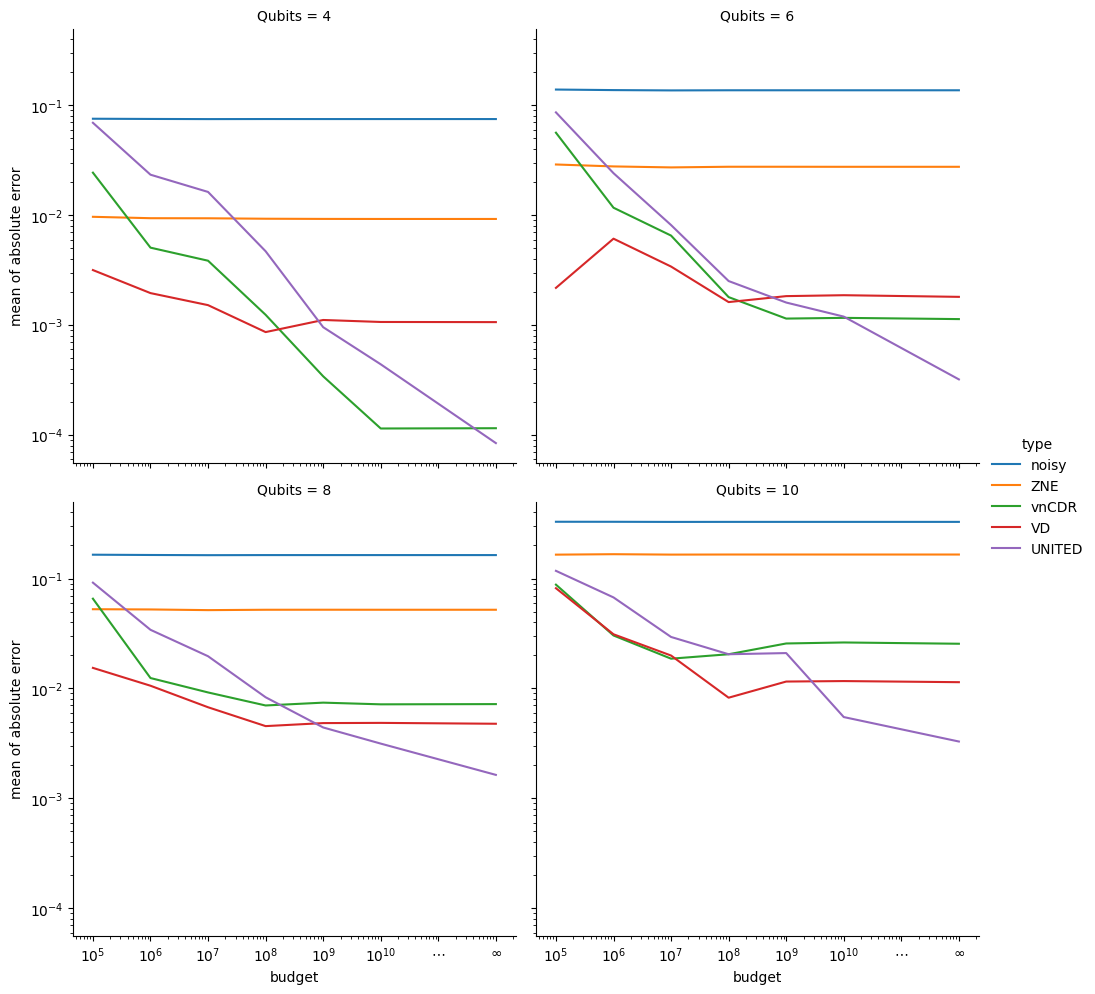

In [4]:
figure_5(maxcut_df,'mean')

## Full data
The full data and filtered data can be either found in the pickles/csv files in the respective folders. This data is processed to have the technique-mitigated values. The data of the COI (circuits of interest) and and training circuits are inside the subfolders. Loading them and their subsequent 'use' is shown here via the reproduction some of the appendix plots. 

In [2]:
# Full processed data, but not filtered
unprocessed_maxcut_df = load_unfiltered_data()
# Training and COI data
raw_data = load_raw_maxcut_data()
train = raw_data['train']
coi = raw_data['coi'].reset_index()

## Appendix plots
Reproduction of the appendix plots with added flexibility, some of the main text plots are only made for the random quantum circuits, but can be made for this dataset as well. 

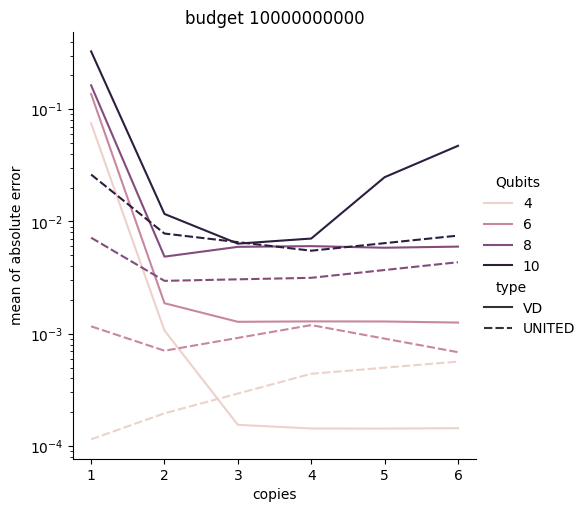

In [20]:
figure_7(maxcut_df)

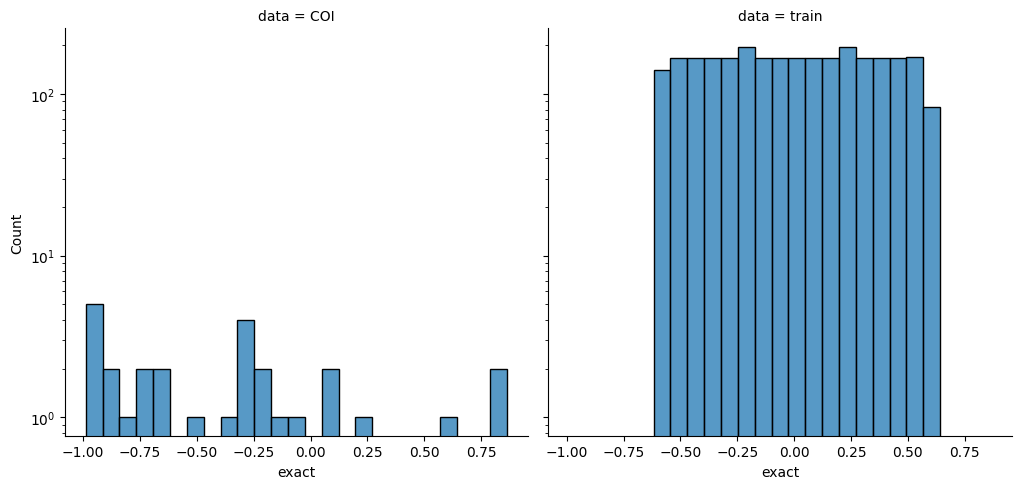

In [6]:
figure_8(train,coi,4)